# Exact simulation of voltage-step protocols

In previous examples, we used CVODE to solve a set of ODEs numerically:

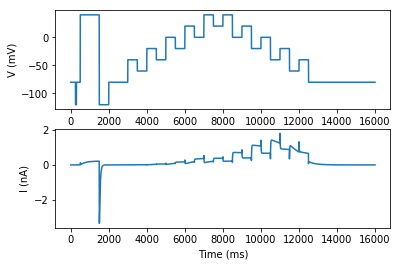

In [2]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

m = myokit.load_model('beattie-2017-ikr-hh.mmt')
p = myokit.load_protocol('staircase-protocol.mmt')
s1 = myokit.Simulation(m, p)

times = np.linspace(0, 15999, 160000)
d = s1.run(160000, log_times=times)

plt.figure()

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.plot(d.time(), d['membrane.V'])

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('I (nA)')
plt.plot(d.time(), d['ikr.IKr'])

plt.show()

For voltage-protocols including only steps (so piecewise-constant protocols), we can use the analytical solutions known for Hodgkin-Huxley and Markov models instead.

## Hodgkin-Huxley models

First, we show how to do this for Hodgkin-Huxley (HH) style components, using the module [`myokit.lib.hh`](https://myokit.readthedocs.io/api_library/hh.html).

First, note that the `ikr` component in the model defines a HH model:


In [3]:
print(m.get('ikr').code())

[ikr]
use membrane.V as V
IKr = g * act * rec * (V - nernst.EK)
    in [nA]
dot(act) = (inf - act) / tau
    inf = k1 * tau
    k1 = p1 * exp(p2 * V)
    k2 = p3 * exp(-p4 * V)
    tau = 1 / (k1 + k2)
g = p9
p1 = 0.000226 [mS/uF]
p2 = 0.0699 [1/mV]
p3 = 3.45e-5 [mS/uF]
p4 = 0.05462 [1/mV]
p5 = 0.0873 [mS/uF]
p6 = 0.00891 [1/mV]
p7 = 0.00515 [mS/uF]
p8 = 0.03158 [1/mV]
p9 = 0.1524 [uS]
dot(rec) = (inf - rec) / tau
    inf = k4 * tau
    k3 = p5 * exp(p6 * V)
    k4 = p7 * exp(-p8 * V)
    tau = 1 / (k3 + k4)




This means that we can use the `from_component` method to quickly generate `HHModel` class:

In [4]:
import myokit.lib.hh

# Specify the variables to keep as parameters
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]

# Create a parametrisable HH model
hh = myokit.lib.hh.HHModel.from_component(m.get('ikr'), parameters=parameters)

HHModelError: The model must define a variable labeled as "membrane_potential".

Uh oh! This method needs to know which variable represents the membrane potential. To do this, we change the model, removing the binding to `pace` and adding a label `membrane_potential`:

In [5]:
m.get('membrane.V').set_binding(None)
m.get('membrane.V').set_label('membrane_potential')

# Create a parametrisable HH model
hh = myokit.lib.hh.HHModel.from_component(m.get('ikr'), parameters=parameters)

Now we have a new type of model:

In [6]:
print(type(m))

print(type(hh))

<class 'myokit._model_api.Model'>
<class 'myokit.lib.hh.HHModel'>


This type of model has some advantages, for example it can easily calculate steady-states:

In [7]:
print(hh.steady_state(-80))

[0.00030894931556590987, 0.60081119944226]


Instead of the default Simulation class, we can now use the analytical simulation class:

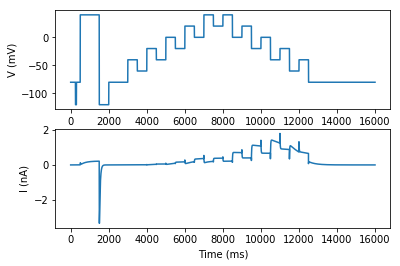

In [8]:
s2 = myokit.lib.hh.AnalyticalSimulation(hh, p)

d2 = s2.run(16000, log_times=times)

plt.figure()

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.plot(d2.time(), d2['membrane.V'])

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('I (nA)')
plt.plot(d2.time(), d2['ikr.IKr'])

plt.show()

The HH model remembers its parameters:

In [9]:
hh.parameters()

['ikr.p1',
 'ikr.p2',
 'ikr.p3',
 'ikr.p4',
 'ikr.p5',
 'ikr.p6',
 'ikr.p7',
 'ikr.p8',
 'ikr.p9']

And the `AnalyticalSimulation` can use this to identify the parameters:

In [10]:
s2.parameters()

[0.000226,
 0.0699,
 3.45e-05,
 0.05462,
 0.0873,
 0.00891,
 0.00515,
 0.03158,
 0.1524]

allowing us to change them:

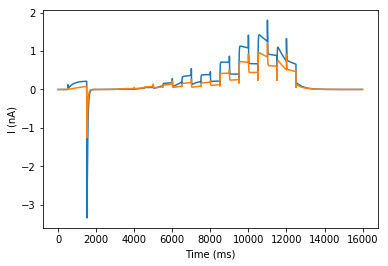

In [11]:
s2.reset()
s2.set_parameters([
    0.000226*0.5,
    0.0699*0.5,
    3.45e-05,
    0.05462,
    0.0873,
    0.00891,
    0.00515,
    0.03158,
    0.1524,
])

d3 = s2.run(16000, log_times=times)

plt.figure()

plt.xlabel('Time (ms)')
plt.ylabel('I (nA)')
plt.plot(d2.time(), d2['ikr.IKr'])
plt.plot(d3.time(), d3['ikr.IKr'])

plt.show()

We can inspect the speed-up offered by this class:

In [12]:
b = myokit.Benchmarker()
s1.run(16000, log_times=times)
print(b.time())
b.reset()
s2.run(16000, log_times=times)
print(b.time())


0.06042218299990054
0.0016701820022717584


A second advantage of analytical methods, is that they have **much lower numerical noise**. This is particularly important for optimisation and inference, because numerical noise in an ODE solution creates unpredictable noise in objective functions and/or likelihoods.

Why? A slight change in parameters will affect the steps chosen by an adaptive solver. In some cases this may be a continuous function of the parameters, so that linearly varying a parameter causes a linear change in the objective function. However, if the algorithm includes any kind of _decision_, a change in a parameter can lead to an abrubt change in the objective function (a type of bifurcation), causing apparent randomness in the objective. Because the adaptive solver has _tolerances_ on how good of a solution it calculates, this effect is invisible on a global scale, because nearby parameters lead to similar results, with similar numerical noise. However, as we zoom in on a point in the parameter space, at some stage the numerical noise will become dominant, so that the objective looks ragged (and full of minima) and difficult to navigate.

The problem can be reduced by choosing tight tolerances, and checking if they are OK for the scale of the problem. Using analytical solvers eliminates this problem to a much larger degree.

## Markov models

Similar classes are available for models written in a Markov formulation:

In [13]:
# Load a Markov model
m2 = myokit.load_model('beattie-2017-ikr-markov.mmt')

print(m2.get('ikr').code())

[ikr]
use membrane.V as V
IKr = p9 * y3 * (V - nernst.EK)
k12 = p1 * exp(p2 * V)
k14 = p7 * exp(-p8 * V)
k21 = p3 * exp(-p4 * V)
k41 = p5 * exp(p6 * V)
p1 = 0.000226 [mS/uF]
p2 = 0.0699 [1/mV]
p3 = 3.45e-5 [mS/uF]
p4 = 0.05462 [1/mV]
p5 = 0.0873 [mS/uF]
p6 = 0.00891 [1/mV]
p7 = 0.00515 [mS/uF]
p8 = 0.03158 [1/mV]
p9 = 0.1524 [mS/uF]
dot(y1) = -k12 * y1 + k21 * y2 + k41 * y4 - k14 * y1
dot(y2) = -k14 * y2 + k41 * y3 + k12 * y1 - k21 * y2
dot(y3) = -k21 * y3 + k12 * y4 + k14 * y2 - k41 * y3
dot(y4) = -k12 * y4 + k21 * y3 + k14 * y1 - k41 * y4




In [14]:
import myokit.lib.markov

# Specify the variables to keep as parameters
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]

# Create a parametrisable HH model
m2.get('membrane.V').set_binding(None)
m2.get('membrane.V').set_label('membrane_potential')
markov = myokit.lib.markov.LinearModel.from_component(m2.get('ikr'), current='ikr.IKr', parameters=parameters)

Again, we can create an analytical simulation object:

In [15]:
s3 = myokit.lib.markov.AnalyticalSimulation(markov, p)

d3 = s3.run(16000, log_times=times)

plt.figure()

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.plot(d3.time(), d3['membrane.V'])

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('I (nA)')
plt.plot(d3.time(), d3['ikr.IKr'])

plt.show()

TypeError: run() got an unexpected keyword argument 'log_times'

Oh dear! [The log_times argument still needs to be implemented](https://github.com/MichaelClerx/myokit/issues/270)

For now, we can do this:

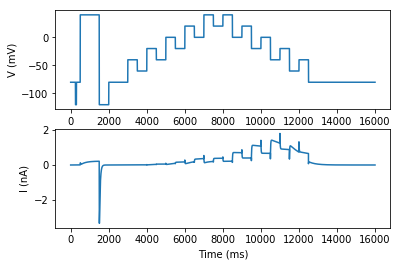

In [16]:
d3 = s3.run(16000, log_interval=0.1)

plt.figure()

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.plot(d3.time(), d3['membrane.V'])

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('I (nA)')
plt.plot(d3.time(), d3['ikr.IKr'])

plt.show()

Let's have another look at the run-times:

In [17]:
b = myokit.Benchmarker()
s1.run(16000, log_times=times)
print(b.time())
b.reset()
s2.run(16000, log_times=times)
print(b.time())
b.reset()
s3.run(16000, log_interval=0.1)
print(b.time())


0.056543635997513775
0.001921783001307631
0.04641252800138318


It seems the markov model class offers less of a speed advantage here!

### Just for fun: discrete simulations

We can also run discrete (multiple singl-channel) simulations with markov models:

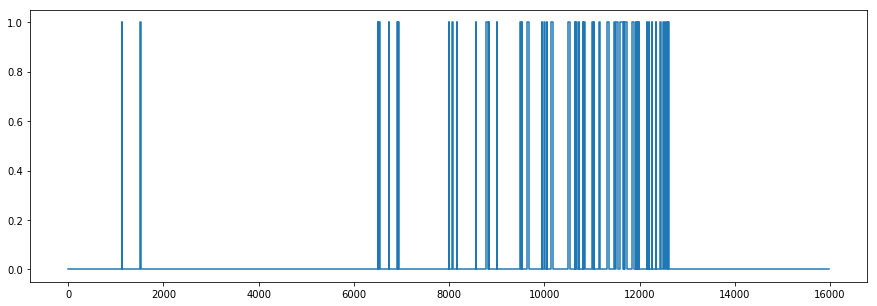

In [27]:
s = myokit.lib.markov.DiscreteSimulation(markov, p, nchannels=1)
d = s.run(16000)

plt.figure(figsize=(15,5))
plt.plot(d.time(), d['ikr.y3'], drawstyle='steps-post')
plt.show()

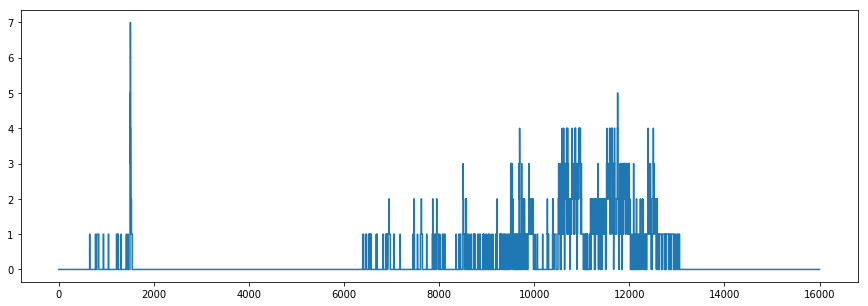

In [31]:
s = myokit.lib.markov.DiscreteSimulation(markov, p, nchannels=10)
d = s.run(16000)

plt.figure(figsize=(15,5))
plt.plot(d.time(), d['ikr.y3'], drawstyle='steps-post')
plt.show()

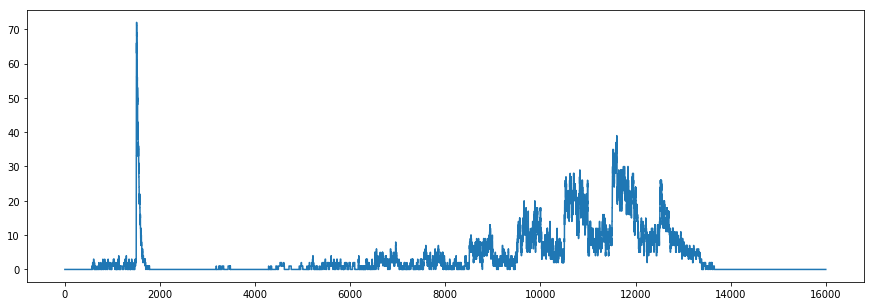

In [32]:
s = myokit.lib.markov.DiscreteSimulation(markov, p, nchannels=100)
d = s.run(16000)

plt.figure(figsize=(15,5))
plt.plot(d.time(), d['ikr.y3'], drawstyle='steps-post')
plt.show()

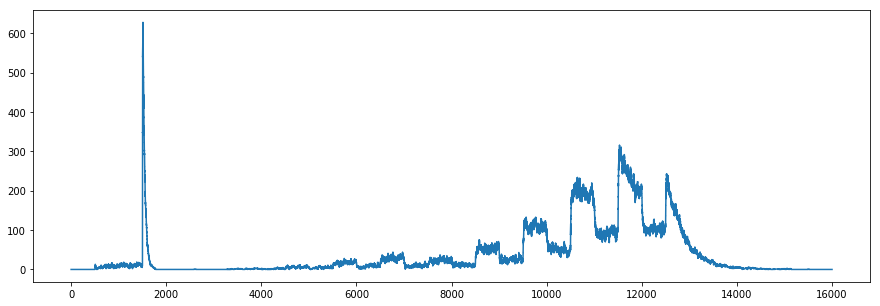

In [33]:
s = myokit.lib.markov.DiscreteSimulation(markov, p, nchannels=1000)
d = s.run(16000)

plt.figure(figsize=(15,5))
plt.plot(d.time(), d['ikr.y3'], drawstyle='steps-post')
plt.show()